In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

import matplotlib
from matplotlib import rc
font = {'size'   : 8}
matplotlib.rc('font', **font)

# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Part 1: Rank order predictions

In [8]:
def rank_order_preds(smis, scos, path):
    new_scos = []
    new_smis = []
    for smi,sco in zip(smis,scos):
        try: 
            new_scos.append(float(sco))
            new_smis.append(smi)
        except:
            continue
    df = pd.DataFrame(zip(new_smis,new_scos), columns = ['smiles','scores'])
    df = df.sort_values(by = 'scores', ascending = False)
    df['rank'] = range(0,len(df))
    
    fig, ax = plt.subplots(figsize = (3,2), dpi = 300)
    plt.plot(df['rank'], df['scores'], color = 'slategrey')
    plt.xlabel('Rank')
    plt.ylabel('Score')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(path + '_score_wrt_rank.png')
    plt.savefig(path + '_score_wrt_rank.svg')
    plt.show()
    
    return(df)

# Part 2: Tanimoto similarity as function of rank

In [9]:
# for every molecule, get similarity to closest drug in a set of drug fps
def get_lowest_tanimoto_from_drug_set(new_set, drug_fps):
    # new_set is list of smiles
    # drug_fps is list of fingerprints of things you want to compare to
    try:
        mols = [Chem.MolFromSmiles(x) for x in new_set]
        fps = [Chem.RDKFingerprint(x) if x is not None else '' for x in mols]
    except Exception as e:
        print(e)
        return([1000])

    best_similarity = []
   
    i = 0
    for mol in fps:
        curr_highest_sim = 0
        if mol == '':
            best_similarity.append('NaN')
            continue
        j = 0
        for drug in drug_fps:
            try: 
                sim = DataStructs.FingerprintSimilarity(mol,drug)
            except Exception as e:
                continue
            if sim > curr_highest_sim and i !=j:
                curr_highest_sim = sim
            j = j + 1
        best_similarity.append(curr_highest_sim)
        i = i + 1 
    return(best_similarity)

def compute_highest_tan_sim_intraset(smis):
    smis = [smi for smi in smis if type(smi) != float]
    mols = [Chem.MolFromSmiles(x) for x in smis]
    fps = [Chem.RDKFingerprint(x) if x is not None else '' for x in mols ]
    tans = get_lowest_tanimoto_from_drug_set(smis, fps)
    return(tans)

def plot_tan_wrt_rank(df, path):
    df = ranks.sort_values(by = 'scores', ascending = False)
    
    fig, ax = plt.subplots(figsize = (3,2), dpi = 300)
    plt.scatter(df['rank'], df['tan'], s = 0.5, color = 'slategrey')
    plt.xlabel('Rank')
    plt.ylabel('Highest Inter-Set Tanimoto')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(path + '_tan_wrt_rank.png')
    plt.savefig(path + '_tan_wrt_rank.svg')
    plt.show()

# Part 3: Tanimoto similarity as function of prediction score


In [10]:
def plot_tan_wrt_score(df, path):
    fig, ax = plt.subplots(figsize = (3,2), dpi = 300)
    plt.scatter(df['scores'], df['tan'], s = 0.5, color = 'slategrey')
    plt.xlabel('Score')
    plt.ylabel('Highest Inter-Set Tanimoto')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(path + '_tan_wrt_score.png')
    plt.savefig(path + '_tan_wrt_score.svg')
    plt.show()

# Part 4: Make final plots - inhibition

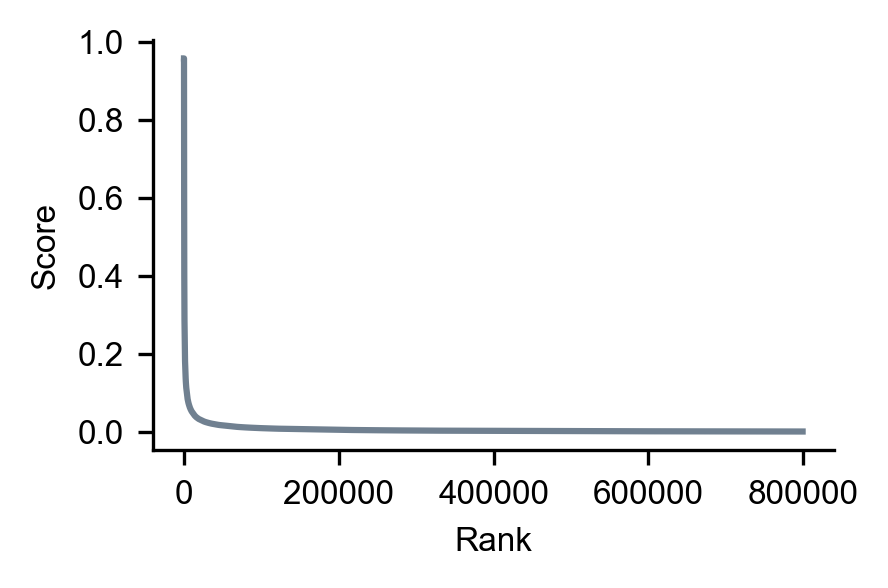

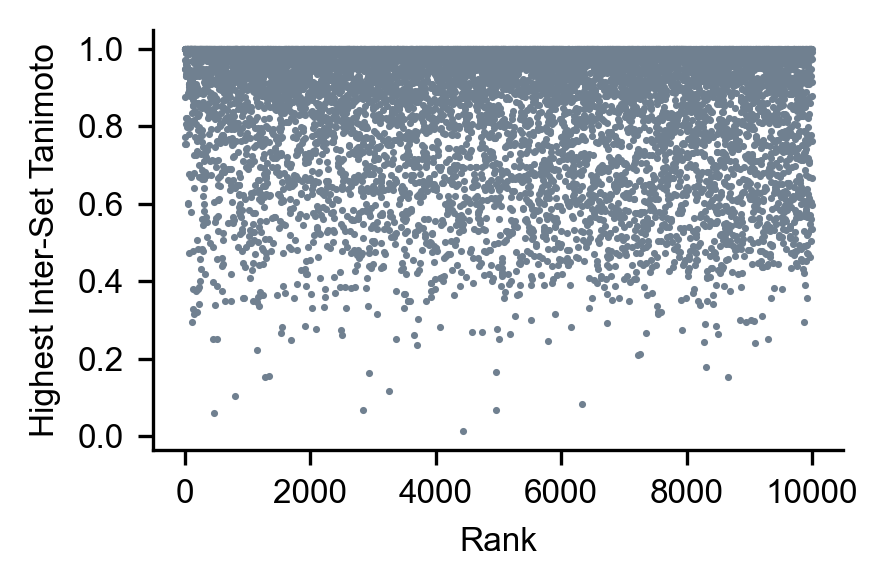

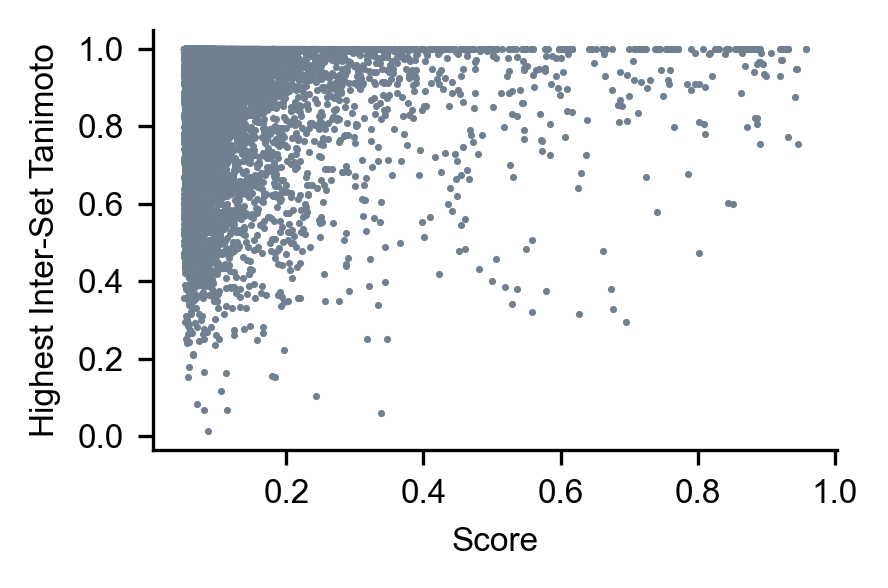

In [11]:
df = pd.read_csv('../out/broad800k_model_predictions_08_20_2021.csv') 
path = '../figure_panels/S2_inh'

smis = list(df['smiles'])
scos = list(df['hit_inh'])

# get ranks
ranks = rank_order_preds(smis, scos, path)

# get tanimotos
ranks = ranks.iloc[0:10000,:]
tans = compute_highest_tan_sim_intraset(ranks['smiles'])
ranks['tan'] = tans

# additional plots
plot_tan_wrt_rank(ranks, path)
plot_tan_wrt_score(ranks, path)

# Part 5: Make final plots - killing

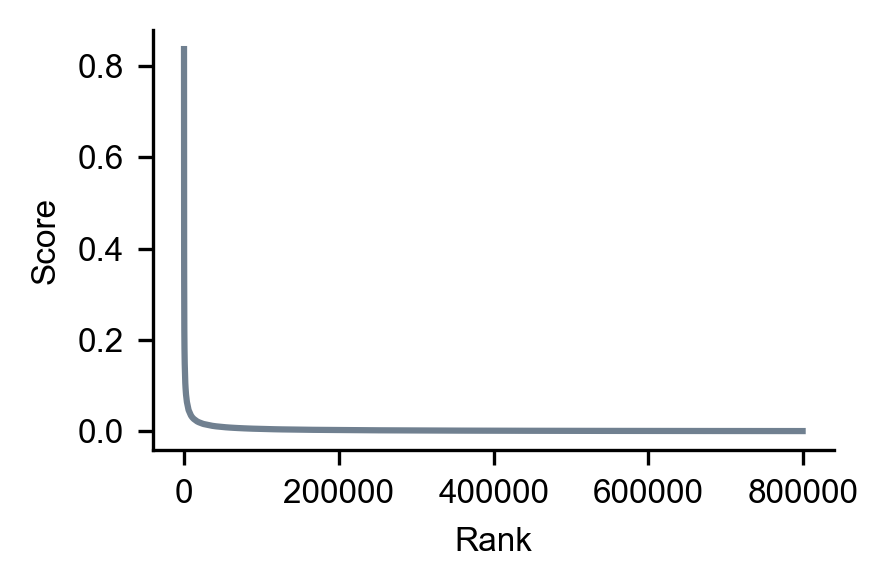

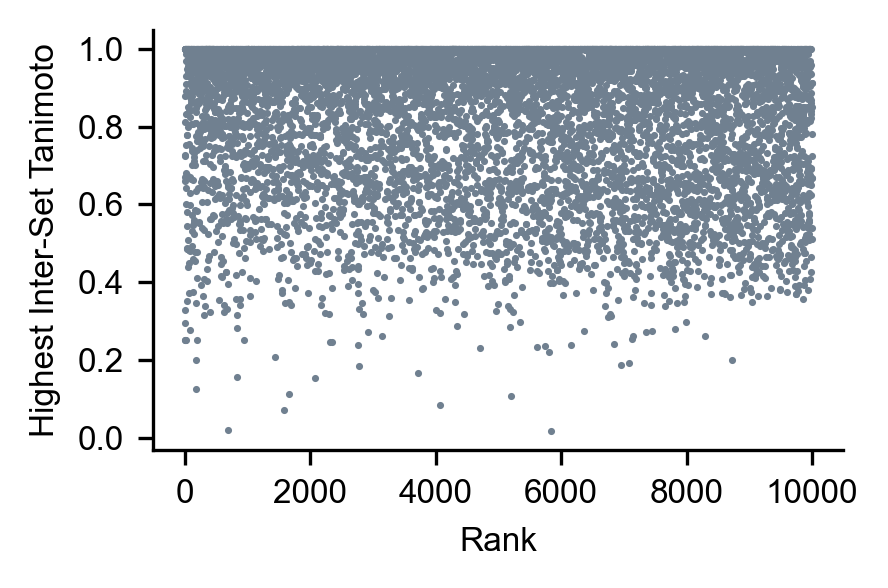

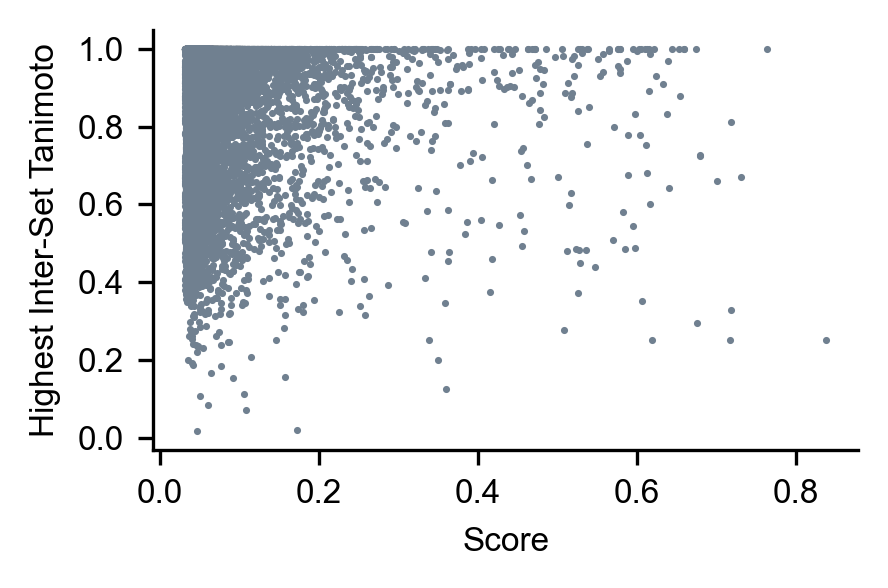

In [12]:
path = '../figure_panels/S2_kill'

smis = list(df['smiles'])
scos = list(df['hit_kill'])

# get ranks
ranks = rank_order_preds(smis, scos, path)

# get tanimotos
ranks = ranks.iloc[0:10000,:]
tans = compute_highest_tan_sim_intraset(ranks['smiles'])
ranks['tan'] = tans

# additional plots
plot_tan_wrt_rank(ranks, path)
plot_tan_wrt_score(ranks, path)